# Dev-Set

## Data Gathering

Importing necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import glob

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from tensorflow.keras import layers

Mounting Google drive



In [2]:
from google.colab import drive
import os
drive.mount('/content/drive/')
os.chdir('/content/drive/MyDrive/CA684_Assignment/')

Mounted at /content/drive/


Loading the Ground truth data from Devset

In [3]:
ground_truth_data = pd.read_csv('Dev-set/Ground-truth/ground-truth.csv')

In [4]:
ground_truth_data.shape

(6000, 5)

In [5]:
ground_truth_data.head()

,video,short-term_memorability,nb_short-term_annotations,long-term_memorability,nb_long-term_annotations
0,video3.webm,0.924,34,0.846,13
1,video4.webm,0.923,33,0.667,12
2,video6.webm,0.863,33,0.700,10
3,video8.webm,0.922,33,0.818,11
4,video10.webm,0.950,34,0.900,10


Creating a correlation matrix to find the importance of each columns

In [6]:
ground_truth_data.corr()

,short-term_memorability,nb_short-term_annotations,long-term_memorability,nb_long-term_annotations
short-term_memorability,1.000000,-0.021178,0.325002,-0.013858
nb_short-term_annotations,-0.021178,1.000000,-0.047093,0.285548
long-term_memorability,0.325002,-0.047093,1.000000,0.036051
nb_long-term_annotations,-0.013858,0.285548,0.036051,1.000000


As both short and long term annotations don't have high correlations, they are dropped

In [7]:
ground_truth_data = ground_truth_data.drop(['nb_short-term_annotations', 'nb_long-term_annotations'], axis=1)
ground_truth_data.head()

,video,short-term_memorability,long-term_memorability
0,video3.webm,0.924,0.846
1,video4.webm,0.923,0.667
2,video6.webm,0.863,0.700
3,video8.webm,0.922,0.818
4,video10.webm,0.950,0.900


## Spearman's correlation coefficient

Method definition for calculating the Spaerman's correlation coefficient

In [8]:
def Get_score(y_predictions,y_true):
    '''Calculation of the Spearman"s correlation coefficient'''
    y_predictions = np.squeeze(y_predictions)
    y_true = np.squeeze(y_true)
    if y_predictions.shape != y_true.shape:
        print('Input shapes are not matching!')
    else:
        if len(y_predictions.shape) == 1:
            Result_value = pd.DataFrame({'y_true':y_true,'y_predictions':y_predictions})
            Final_score = Result_value[['y_true','y_predictions']].corr(method='spearman',min_periods=1)
            print('The Spearman\'s correlation coefficient is: %.3f' % Final_score.iloc[1][0])
        else:
            for pred_data in range(y_predictions.shape[1]):
                Get_score(y_predictions[:,pred_data],y_true[:,pred_data])

## Feature Engineering

### C3D Features

Method definition for reading C3D features from a particular video file



In [9]:
def read_C3D(fname):
    """Scan vectors from file"""
    with open(fname) as f:
        for line in f:
            C3D =[float(item) for item in line.split()] # convert to float type, using default separator
    return C3D

Iterating through the C3D dev set folder to gather every video file data

In [10]:
c3d_fea_list= [] # Creation of a list to store the extracted C3D features of a video file
c3d_video_list = [] #Creation of a list to store the video file names

for c3d_filename in glob.glob('Dev-set/C3D/*.txt'):
    c3d_data= read_C3D(c3d_filename)
    c3d_fea_list.append(c3d_data)
    c3d_video_list.append(((c3d_filename.split('/')[-1]).split('.')[0])+ '.webm') 

In [11]:
len(c3d_fea_list)

6000

In [12]:
len(c3d_fea_list[0])

101

In [13]:
c3d_df = pd.DataFrame(np.array(c3d_fea_list).reshape(6000,101))
c3d_df["video"] = c3d_video_list

In [14]:
c3d_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,video
0,0.010858,0.010386,0.000000,0.000000e+00,0.000000e+00,0.000000,2.700000e-07,0.000000,1.000000e-08,3.400000e-07,8.000000e-08,1.000000e-08,0.000004,0.000105,0.000000e+00,4.000000e-08,1.000000e-08,0.000000,0.000000,1.331800e-04,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,7.600000e-07,0.000000,9.800000e-07,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,6.000000e-08,0.000021,5.000000e-08,0.000000e+00,1.000000e-08,3.000000e-08,2.000000e-08,0.000000e+00,...,0.970125,0.000016,0.001298,0.000032,0.000001,0.000000,0.000000,1.000000e-08,2.500000e-07,0.000000e+00,0.000000,5.000000e-08,0.000000,1.000000e-08,1.000000e-08,4.200000e-07,0.000000e+00,3.000000e-08,2.000000e-08,0.000000,0.000000,0.000000,6.000000e-08,0.000000,0.000000,9.000000e-08,0.000000,0.000000e+00,1.100000e-07,1.400000e-07,0.000000,0.000000,1.700000e-07,0.000000,0.000000e+00,1.000000e-08,1.300000e-06,2.600000e-06,8.000000e-08,video6632.webm
1,0.000200,0.000065,0.993807,2.000000e-07,4.700000e-07,0.000073,3.700000e-06,0.000337,6.710000e-06,2.290000e-06,6.380000e-06,7.340000e-06,0.000019,0.000007,3.240000e-06,3.810000e-06,1.411000e-05,0.000001,0.000003,2.300000e-07,1.900000e-07,0.002938,5.200000e-07,9.200000e-07,1.136000e-05,0.000011,3.310400e-04,9.200000e-07,0.000022,8.000000e-08,0.000028,0.000013,5.778000e-05,0.000037,1.683000e-05,6.860000e-06,3.990000e-06,8.030000e-06,1.450000e-06,3.800000e-07,...,0.000027,0.000013,0.000077,0.000050,0.000138,0.000012,0.000007,4.100000e-07,5.440000e-06,3.400000e-07,0.000007,8.399000e-05,0.000004,3.970000e-06,5.900000e-07,1.285300e-04,8.800000e-07,2.228000e-05,1.105000e-05,0.000003,0.000015,0.000014,4.090000e-06,0.000003,0.000005,4.920000e-06,0.000005,6.400000e-07,2.372000e-05,6.610000e-06,0.000010,0.000002,5.800000e-06,0.000001,1.490000e-06,1.170000e-05,1.500000e-07,8.300000e-07,1.060000e-04,video6634.webm
2,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000008,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.999985,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.120000e-06,video6633.webm
3,0.005959,0.004765,0.003757,5.787100e-04,7.344000e-05,0.000129,4.665300e-04,0.010266,3.028100e-04,2.196500e-04,2.521800e-04,2.963730e-03,0.000032,0.000592,3.260000e-05,1.466430e-03,2.430700e-04,0.000181,0.004019,2.390960e-03,1.206900e-04,0.008488,5.216200e-04,4.164600e-04,1.643420e-02,0.049686,1.470550e-03,5.432000e-05,0.001055,5.442770e-03,0.000173,0.024688,9.640700e-04,0.000880,1.140529e-02,4.522160e-03,8.594500e-04,6.573000e-04,6.942400e-04,1.823110e-03,...,0.000639,0.014109,0.000472,0.002461,0.004046,0.000905,0.000997,2.514660e-03,1.587440e-03,1.125030e-03,0.001008,2.133877e-02,0.000647,1.373010e-03,9.568000e-05,5.635083e-02,1.628000e-05,5.379910e-03,6.020020e-03,0.046499,0.023942,0.020658,3.349520e-03,0.002637,0.000094,1.170705e-02,0.000229,9.789210e-03,2.764390e-03,8.052350e-03,0.003992,0.004137,3.670390e-02,0.000767,3.692100e-04,1.251980e-02,8.422000e-05,1.159825e-02,1.155040e-03,video6645.webm
4,0.005782,0.000306,0.004011,1.007000e-05,1.034000e-05,0.000002,3.160000e-06,0.000003,1.984000e-0

Merging the C3D features with the ground truth based on video in order to sort the values

In [15]:
c3d_final_df = pd.merge(ground_truth_data, c3d_df, on='video')

In [16]:
c3d_final_df.head()

,video,short-term_memorability,long-term_memorability,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,...,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100
0,video3.webm,0.924,0.846,0.020249,0.001578,0.000826,0.000945,0.000063,0.000003,0.001162,0.000097,0.000022,0.000010,0.000337,0.000636,1.111700e-04,0.001008,0.000004,0.000631,3.905000e-05,0.000041,0.000091,0.000303,1.541000e-05,0.000032,5.221000e-05,0.000062,0.017465,0.000666,0.000065,0.000054,0.000273,0.001386,0.000003,0.001356,0.000517,2.426120e-03,0.002719,2.770000e-06,0.001557,...,0.096647,0.004458,0.011840,0.000287,0.002195,0.002792,0.000018,0.003365,0.000061,0.000573,0.000273,0.000034,0.006737,0.000021,0.000098,2.502000e-05,0.005768,2.990000e-06,0.000085,0.000607,0.000461,0.001189,0.000270,0.000127,0.000106,0.000154,0.000567,0.000020,0.000894,0.001079,0.001042,0.000161,0.000257,0.046617,0.000156,0.000006,0.000537,0.000339,0.008437,0.000470
1,video4.webm,0.923,0.667,0.000118,0.000891,0.000188,0.000045,0.000063,0.000002,0.000641,0.000011,0.000017,0.000014,0.000336,0.004081,5.900000e-07,0.000411,0.000003,0.000243,6.600000e-07,0.000002,0.000535,0.000278,4.804000e-05,0.001153,2.792000e-05,0.000040,0.022276,0.004529,0.000020,0.000029,0.000045,0.060436,0.000039,0.027208,0.000074,2.719000e-05,0.000623,2.609600e-04,0.000183,...,0.000372,0.000154,0.000148,0.000086,0.000267,0.000014,0.001430,0.004417,0.000064,0.000105,0.003129,0.000055,0.000061,0.000025,0.004283,1.032000e-05,0.000062,2.903000e-05,0.000374,0.000139,0.741702,0.007178,0.000346,0.000104,0.000181,0.000052,0.004839,0.000078,0.042325,0.000623,0.000582,0.000393,0.000864,0.000947,0.000136,0.000007,0.000360,0.000159,0.001025,0.000020
2,video6.webm,0.863,0.700,0.011765,0.000746,0.000784,0.000013,0.000007,0.000028,0.000041,0.000014,0.000041,0.000083,0.000048,0.000080,1.066610e-03,0.000958,0.000011,0.000070,2.992000e-05,0.000038,0.000031,0.000008,9.700000e-07,0.002905,1.849000e-05,0.000013,0.000192,0.000050,0.000532,0.000027,0.000051,0.000010,0.000005,0.000029,0.000033,3.260172e-02,0.000034,7.100000e-07,0.000006,...,0.876291,0.005509,0.008852,0.000399,0.000069,0.013166,0.000015,0.000044,0.000520,0.000046,0.000007,0.000024,0.010491,0.000475,0.000023,5.590000e-06,0.005554,2.500000e-07,0.000057,0.000328,0.000149,0.001844,0.000008,0.000103,0.000030,0.000005,0.000179,0.000001,0.000006,0.000215,0.000224,0.000003,0.000031,0.002538,0.000104,0.000005,0.000064,0.005380,0.001027,0.001384
3,video8.webm,0.922,0.818,0.000223,0.000165,0.000007,0.000016,0.000005,0.000014,0.000154,0.000008,0.000004,0.000009,0.001057,0.000126,3.404000e-05,0.000004,0.000006,0.000012,1.940000e-06,0.000003,0.001759,0.000005,8.330000e-06,0.000027,3.200000e-07,0.000010,0.000137,0.000006,0.000005,0.000008,0.000008,0.000611,0.000166,0.583214,0.000004,2.100000e-07,0.000002,2.136000e-05,0.000003,...,0.000009,0.000007,0.000005,0.000539,0.000035,0.000391,0.000021,0.000043,0.000010,0.000028,0.012471,0.006671,0.001187,0.000002,0.119488,5.600000e-07,0.000004,4.250000e-06,0.000040,0.000148,0.103989,0.058989,0.000002,0.000069,0.000004,0.000130,0.001182,0.000003,0.000006,0.000044,0.000046,0.000009,0.000023,0.000053,0.000048,0.000019,0.000001,0.000004,0.000380,0.000029
4,video10.webm,0.950,0.900,0.000090,0.000615,0.003436,0.001281,0.003551,0.000313,0.000042,0.000018,0.000157,0.000117,0.000256,0.000116,3.234800e-04,0.009888,0.000001,0.000576,3.004000e-05,0.000008,0.002029,0.000016,7.690000e-06,0.007324,2.863000e-05,0.000015,0.035220,0.000153,0.001053,0.000031,0.000026,0.001376,0.000215,0.001759,0.000013,1.698540e-03,0.000248,1.754577e-02,0.000260,...,0.000236,0.000046,0.000027,0.000203,0.010644,0.000252,0.000349,0.001776,0.000006,0.001443,0.000146,0.019003,0.000584,0.000027,0.000692,5.650000e-06,0.000403,2.894700e-04,0.000197,0.001254,0.005257,0.045808,0.000008,0.000296,0.003893,0.000318,0.000048,0.000018,0.000264,0.000026,0.000037,0.000690,0.000171,0.00023

Creating a csv file to store the extracted C3D features for future use

In [17]:
c3d_final_df.to_csv('/content/drive/My Drive/Features Files/c3d_final_df.csv')

In [18]:
c3d_final_df = pd.read_csv('/content/drive/My Drive/Features Files/c3d_final_df.csv')

In [19]:
c3d_final_df.shape

(6000, 105)

In [34]:
c3d_final_df.drop(c3d_final_df.columns[0] , axis =1, inplace = True)

In [35]:
c3d_final_df.head()

,video,short-term_memorability,long-term_memorability,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,...,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100
0,video3.webm,0.924,0.846,0.020249,0.001578,0.000826,0.000945,0.000063,0.000003,0.001162,0.000097,0.000022,0.000010,0.000337,0.000636,1.111700e-04,0.001008,0.000004,0.000631,3.905000e-05,0.000041,0.000091,0.000303,1.541000e-05,0.000032,5.221000e-05,0.000062,0.017465,0.000666,0.000065,0.000054,0.000273,0.001386,0.000003,0.001356,0.000517,2.426120e-03,0.002719,2.770000e-06,0.001557,...,0.096647,0.004458,0.011840,0.000287,0.002195,0.002792,0.000018,0.003365,0.000061,0.000573,0.000273,0.000034,0.006737,0.000021,0.000098,2.502000e-05,0.005768,2.990000e-06,0.000085,0.000607,0.000461,0.001189,0.000270,0.000127,0.000106,0.000154,0.000567,0.000020,0.000894,0.001079,0.001042,0.000161,0.000257,0.046617,0.000156,0.000006,0.000537,0.000339,0.008437,0.000470
1,video4.webm,0.923,0.667,0.000118,0.000891,0.000188,0.000045,0.000063,0.000002,0.000641,0.000011,0.000017,0.000014,0.000336,0.004081,5.900000e-07,0.000411,0.000003,0.000243,6.600000e-07,0.000002,0.000535,0.000278,4.804000e-05,0.001153,2.792000e-05,0.000040,0.022276,0.004529,0.000020,0.000029,0.000045,0.060436,0.000039,0.027208,0.000074,2.719000e-05,0.000623,2.609600e-04,0.000183,...,0.000372,0.000154,0.000148,0.000086,0.000267,0.000014,0.001430,0.004417,0.000064,0.000105,0.003129,0.000055,0.000061,0.000025,0.004283,1.032000e-05,0.000062,2.903000e-05,0.000374,0.000139,0.741702,0.007178,0.000346,0.000104,0.000181,0.000052,0.004839,0.000078,0.042325,0.000623,0.000582,0.000393,0.000864,0.000947,0.000136,0.000007,0.000360,0.000159,0.001025,0.000020
2,video6.webm,0.863,0.700,0.011765,0.000746,0.000784,0.000013,0.000007,0.000028,0.000041,0.000014,0.000041,0.000083,0.000048,0.000080,1.066610e-03,0.000958,0.000011,0.000070,2.992000e-05,0.000038,0.000031,0.000008,9.700000e-07,0.002905,1.849000e-05,0.000013,0.000192,0.000050,0.000532,0.000027,0.000051,0.000010,0.000005,0.000029,0.000033,3.260172e-02,0.000034,7.100000e-07,0.000006,...,0.876291,0.005509,0.008852,0.000399,0.000069,0.013166,0.000015,0.000044,0.000520,0.000046,0.000007,0.000024,0.010491,0.000475,0.000023,5.590000e-06,0.005554,2.500000e-07,0.000057,0.000328,0.000149,0.001844,0.000008,0.000103,0.000030,0.000005,0.000179,0.000001,0.000006,0.000215,0.000224,0.000003,0.000031,0.002538,0.000104,0.000005,0.000064,0.005380,0.001027,0.001384
3,video8.webm,0.922,0.818,0.000223,0.000165,0.000007,0.000016,0.000005,0.000014,0.000154,0.000008,0.000004,0.000009,0.001057,0.000126,3.404000e-05,0.000004,0.000006,0.000012,1.940000e-06,0.000003,0.001759,0.000005,8.330000e-06,0.000027,3.200000e-07,0.000010,0.000137,0.000006,0.000005,0.000008,0.000008,0.000611,0.000166,0.583214,0.000004,2.100000e-07,0.000002,2.136000e-05,0.000003,...,0.000009,0.000007,0.000005,0.000539,0.000035,0.000391,0.000021,0.000043,0.000010,0.000028,0.012471,0.006671,0.001187,0.000002,0.119488,5.600000e-07,0.000004,4.250000e-06,0.000040,0.000148,0.103989,0.058989,0.000002,0.000069,0.000004,0.000130,0.001182,0.000003,0.000006,0.000044,0.000046,0.000009,0.000023,0.000053,0.000048,0.000019,0.000001,0.000004,0.000380,0.000029
4,video10.webm,0.950,0.900,0.000090,0.000615,0.003436,0.001281,0.003551,0.000313,0.000042,0.000018,0.000157,0.000117,0.000256,0.000116,3.234800e-04,0.009888,0.000001,0.000576,3.004000e-05,0.000008,0.002029,0.000016,7.690000e-06,0.007324,2.863000e-05,0.000015,0.035220,0.000153,0.001053,0.000031,0.000026,0.001376,0.000215,0.001759,0.000013,1.698540e-03,0.000248,1.754577e-02,0.000260,...,0.000236,0.000046,0.000027,0.000203,0.010644,0.000252,0.000349,0.001776,0.000006,0.001443,0.000146,0.019003,0.000584,0.000027,0.000692,5.650000e-06,0.000403,2.894700e-04,0.000197,0.001254,0.005257,0.045808,0.000008,0.000296,0.003893,0.000318,0.000048,0.000018,0.000263,0.000026,0.000037,0.000690,0.000171,0.00023

### Train Test split for C3D

Inputting the C3D features for the train test split

In [149]:
X = c3d_final_df.iloc[0:,3:].values
y = ground_truth_data.iloc[0:,1:3].values 


Performing train test split

In [150]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

### ML models with C3D features

Linear Regression

In [39]:
LNR_model = LinearRegression()
LNR_model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [40]:
LNR_predictions = LNR_model.predict(X_test)
Get_score(LNR_predictions, y_test)

The Spearman's correlation coefficient is: 0.261
The Spearman's correlation coefficient is: 0.139


Random Forest

In [151]:
RFR_model = RandomForestRegressor(n_estimators=1000, max_depth= 60, max_leaf_nodes= 3,max_features = 4, bootstrap = True,random_state = 42, verbose = 2)
RFR_model.fit(X_train, y_train)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 1000
building tree 2 of 1000
building tree 3 of 1000
building tree 4 of 1000
building tree 5 of 1000
building tree 6 of 1000
building tree 7 of 1000
building tree 8 of 1000
building tree 9 of 1000
building tree 10 of 1000
building tree 11 of 1000
building tree 12 of 1000
building tree 13 of 1000
building tree 14 of 1000
building tree 15 of 1000
building tree 16 of 1000
building tree 17 of 1000
building tree 18 of 1000
building tree 19 of 1000
building tree 20 of 1000
building tree 21 of 1000
building tree 22 of 1000
building tree 23 of 1000
building tree 24 of 1000
building tree 25 of 1000
building tree 26 of 1000
building tree 27 of 1000
building tree 28 of 1000
building tree 29 of 1000
building tree 30 of 1000
building tree 31 of 1000
building tree 32 of 1000
building tree 33 of 1000
building tree 34 of 1000
building tree 35 of 1000
building tree 36 of 1000
building tree 37 of 1000
building tree 38 of 1000
building tree 39 of 1000
building tree 40 of 1000
building 

[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    6.0s finished


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=60, max_features=4, max_leaf_nodes=3,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=None, oob_score=False,
                      random_state=42, verbose=2, warm_start=False)

In [152]:
RFR_predictions = RFR_model.predict(X_test)
Get_score(RFR_predictions, y_test)

The Spearman's correlation coefficient is: 0.251
The Spearman's correlation coefficient is: 0.143


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.1s finished


Gradient Boosting

Training separately for short term and long term

In [43]:
y_short_term = ground_truth_data.iloc[:,1:2].values
y_long_term = ground_truth_data.iloc[:,2:3].values

X_short_train,X_short_test,y_short_train,y_short_test = train_test_split(X,y_short_term,test_size=0.2,random_state=40)
X_long_train,X_long_test,y_long_train,y_long_test = train_test_split(X,y_long_term,test_size=0.2,random_state=40)

Gradient boosting for short term

In [44]:
GBR_model= GradientBoostingRegressor()
GBR_model.fit(X_short_train,y_short_train)

GBR_short_predictions = GBR_model.predict(X_short_test)
Get_score(GBR_short_predictions,y_short_test)

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The Spearman's correlation coefficient is: 0.289


Gradient boosting for long term

In [45]:
GBR_model.fit(X_long_train,y_long_train)

GBR_long_predictions = GBR_model.predict(X_long_test)
Get_score(GBR_long_predictions,y_long_test)

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The Spearman's correlation coefficient is: 0.130


Neural Network

Scaling the input data

In [46]:
std_sc = StandardScaler()
X_short_train = std_sc.fit_transform(X_short_train)
X_short_test = std_sc.transform(X_short_test)

X_long_train = std_sc.fit_transform(X_long_train)
X_long_test = std_sc.transform(X_long_test)

In [50]:
# Initialising the NN model
NN_model = Sequential()

# Input layer and first hidden layer is added
NN_model.add(Dense(32, activation = 'relu', input_dim = 101))

# Second hidden layer is added
NN_model.add(Dense(units = 32, activation = 'relu'))

# Third hidden layer is added
NN_model.add(Dense(units = 32, activation = 'relu'))

# Output layer is added
NN_model.add(Dense(units = 1))

Compiling the Neural Network model

In [51]:
NN_model.compile(optimizer = 'adam',loss = 'mean_squared_error')

Neural Network- short term predictions with C3D features



In [52]:
NN_model.fit(X_short_train, y_short_train, batch_size = 10, epochs = 45)
NN_short_predictions = NN_model.predict(X_short_test)
Get_score(NN_short_predictions, y_short_test)

Epoch 1/45
480/480 [==============================] - 1s 1ms/step - loss: 0.2496
Epoch 2/45
480/480 [==============================] - 1s 1ms/step - loss: 0.0210
Epoch 3/45
480/480 [==============================] - 1s 1ms/step - loss: 0.0113
Epoch 4/45
480/480 [==============================] - 1s 1ms/step - loss: 0.0090
Epoch 5/45
480/480 [==============================] - 1s 1ms/step - loss: 0.0066
Epoch 6/45
480/480 [==============================] - 1s 1ms/step - loss: 0.0071
Epoch 7/45
480/480 [==============================] - 1s 1ms/step - loss: 0.0066
Epoch 8/45
480/480 [==============================] - 1s 1ms/step - loss: 0.0066
Epoch 9/45
480/480 [==============================] - 1s 1ms/step - loss: 0.0072
Epoch 10/45
480/480 [==============================] - 1s 1ms/step - loss: 0.0059
Epoch 11/45
480/480 [==============================] - 1s 1ms/step - loss: 0.0065
Epoch 12/45
480/480 [==============================] - 1s 1ms/step - loss: 0.0059
Epoch 13/45
480/480 [====

Neural Network- long term predictions with C3D features

In [53]:
NN_model.fit(X_long_train, y_long_train, batch_size = 10, epochs = 45)
NN_long_predictions = NN_model.predict(X_long_test)
Get_score(NN_long_predictions, y_long_test)

Epoch 1/45
480/480 [==============================] - 1s 1ms/step - loss: 0.0211
Epoch 2/45
480/480 [==============================] - 1s 1ms/step - loss: 0.0197
Epoch 3/45
480/480 [==============================] - 1s 1ms/step - loss: 0.0190
Epoch 4/45
480/480 [==============================] - 1s 2ms/step - loss: 0.0184
Epoch 5/45
480/480 [==============================] - 1s 1ms/step - loss: 0.0178
Epoch 6/45
480/480 [==============================] - 1s 1ms/step - loss: 0.0174
Epoch 7/45
480/480 [==============================] - 1s 1ms/step - loss: 0.0169
Epoch 8/45
480/480 [==============================] - 1s 1ms/step - loss: 0.0165
Epoch 9/45
480/480 [==============================] - 1s 1ms/step - loss: 0.0161
Epoch 10/45
480/480 [==============================] - 1s 2ms/step - loss: 0.0159
Epoch 11/45
480/480 [==============================] - 1s 1ms/step - loss: 0.0156
Epoch 12/45
480/480 [==============================] - 1s 1ms/step - loss: 0.0153
Epoch 13/45
480/480 [====

### HMP features

Method definition for reading HMP features from a particular video file

In [55]:
def read_HMP(fname):
    """Scan HMP(Histogram of Motion Patterns) features from file"""
    with open(fname) as f:
        for line in f:
            pairs=line.split()
            HMP_temp = { int(p.split(':')[0]) : float(p.split(':')[1]) for p in pairs}
    # there are 6075 bins, fill zeros
    HMP = np.zeros(6075)
    for idx in HMP_temp.keys():
        HMP[idx-1] = HMP_temp[idx]            
    return HMP

Iterating through the HMP dev set folder to gather every video file data

In [56]:
HMP_fea_list= []
HMP_video_list = []
for filename in glob.glob('Dev-set/HMP/*.txt'):
    HMP_data= read_HMP(filename)
    HMP_fea_list.append(HMP_data)
    HMP_video_list.append(((filename.split('/')[-1]).split('.')[0])+ '.webm') 

In [57]:
HMP_df = pd.DataFrame(np.array(HMP_fea_list).reshape(6000,6075))
HMP_df["video"] = HMP_video_list

In [58]:
HMP_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,6036,6037,6038,6039,6040,6041,6042,6043,6044,6045,6046,6047,6048,6049,6050,6051,6052,6053,6054,6055,6056,6057,6058,6059,6060,6061,6062,6063,6064,6065,6066,6067,6068,6069,6070,6071,6072,6073,6074,video
0,0.012099,0.001466,0.000017,0.0,0.000683,0.000007,0.0,0.000000,0.000007,0.0,0.0,0.0,0.0,0.000170,0.000002,0.0,0.000002,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000239,0.000324,0.000151,0.000106,0.000050,0.000014,0.000156,0.000123,0.000031,0.000163,0.000177,0.000097,0.000047,0.000021,0.000002,0.000019,0.000021,0.000000,0.000002,0.000009,0.000002,0.000059,0.000024,0.000007,0.000057,0.000052,0.000012,0.000026,0.000007,0.000014,0.000057,0.000028,0.000007,0.000059,0.000097,0.000012,0.000135,0.000111,0.000076,video6634.webm
1,0.078170,0.013597,0.000122,0.0,0.005590,0.000074,0.0,0.000000,0.000026,0.0,0.0,0.0,0.0,0.001137,0.000017,0.0,0.000000,0.000017,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000069,0.000091,0.000026,0.000061,0.000022,0.000004,0.000091,0.000048,0.000013,0.000043,0.000095,0.000030,0.000043,0.000013,0.000000,0.000039,0.000026,0.000000,0.000009,0.000013,0.000000,0.000069,0.000026,0.000004,0.000143,0.000139,0.000009,0.000017,0.000043,0.000022,0.000043,0.000026,0.000004,0.000078,0.000074,0.000022,0.000052,0.000082,0.000061,video6633.webm
2,0.112506,0.014053,0.000263,0.0,0.043205,0.000560,0.0,0.000005,0.000364,0.0,0.0,0.0,0.0,0.002472,0.000206,0.0,0.000002,0.000064,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000310,0.000629,0.000263,0.000145,0.000061,0.000002,0.000098,0.000248,0.000007,0.000125,0.000354,0.000076,0.000135,0.000049,0.000000,0.000074,0.000103,0.000000,0.000012,0.000039,0.000002,0.000066,0.000012,0.000002,0.000098,0.000221,0.000012,0.000029,0.000076,0.000022,0.000261,0.000069,0.000000,0.000157,0.000558,0.000017,0.000285,0.000504,0.000179,video6639.webm
3,0.066072,0.012682,0.000283,0.0,0.006425,0.000375,0.0,0.000002,0.000174,0.0,0.0,0.0,0.0,0.002373,0.000152,0.0,0.000002,0.000102,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000278,0.000744,0.000484,0.000155,0.000077,0.000000,0.000161,0.000563,0.000084,0.000132,0.000375,0.000358,0.000227,0.000075,0.000002,0.000077,0.000135,0.000007,0.000009,0.000011,0.000007,0.000190,0.000049,0.000004,0.000305,0.001002,0.000099,0.000038,0.000106,0.000075,0.000495,0.000210,0.000002,0.000342,0.002027,0.000124,0.000307,0.001239,0.001047,video6635.webm
4,0.030360,0.005834,0.000169,0.0,0.006578,0.000542,0.0,0.000016,0.000373,0.0,0.0,0.0,0.0,0.001041,0.000113,0.0,0.000007,0.000102,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000696,0.001019,0.000197,0.000239,0.000111,0.000011,0.000298,0.000389,0.000056,0.000291,0.000395,0.000090,0.000115,0.000052,0.000002,0.000054,0.000070,0.000007,0.000014,0.000041,0.000011,0.000124,0.000045,0.000005,0.000176,0.000181,0.000029,0.000052,0.000090,0.000027,0.000199,0.000061,0.000002,0.000228,0.000253,0.000023,0.000359,0.000375,0.000088,video6637.webm


Merging the C3D features with the ground truth based on video in order to sort the values

In [59]:
HMP_final_df = pd.merge(ground_truth_data, HMP_df, on='video')

In [60]:
HMP_final_df.head()

,video,short-term_memorability,long-term_memorability,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,...,6035,6036,6037,6038,6039,6040,6041,6042,6043,6044,6045,6046,6047,6048,6049,6050,6051,6052,6053,6054,6055,6056,6057,6058,6059,6060,6061,6062,6063,6064,6065,6066,6067,6068,6069,6070,6071,6072,6073,6074
0,video3.webm,0.924,0.846,0.125563,0.024036,0.000314,0.0,0.015864,0.000358,0.0,0.000000,0.000086,0.0,0.0,0.0,0.0,0.002795,0.000054,0.0,0.000000,0.000037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000002,0.000173,0.000459,0.000000,0.000148,0.000104,0.000000,0.000121,0.000551,0.000000,0.000114,0.000884,0.000002,0.000116,0.000077,0.000002,0.000027,0.000136,0.000000,0.000000,0.000002,0.000000,0.000091,0.000035,0.000000,0.000163,0.000467,0.000002,0.000010,0.000017,0.000000,0.000393,0.000279,0.000000,0.000289,0.001926,0.000000,0.000086,0.000580,0.000000
1,video4.webm,0.923,0.667,0.007526,0.001421,0.000068,0.0,0.001184,0.000143,0.0,0.000000,0.000079,0.0,0.0,0.0,0.0,0.000246,0.000024,0.0,0.000000,0.000042,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000685,0.000308,0.001054,0.000751,0.000176,0.000062,0.000000,0.000123,0.000398,0.000086,0.000246,0.000433,0.000446,0.000143,0.000053,0.000000,0.000053,0.000099,0.000009,0.000004,0.000033,0.000004,0.000051,0.000035,0.000000,0.000062,0.000358,0.000035,0.000024,0.000083,0.000053,0.000244,0.000066,0.000000,0.000081,0.000617,0.000094,0.000220,0.000762,0.001224
2,video6.webm,0.863,0.700,0.109584,0.018978,0.000289,0.0,0.008774,0.000208,0.0,0.000002,0.000088,0.0,0.0,0.0,0.0,0.002046,0.000061,0.0,0.000000,0.000038,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000083,0.000057,0.000158,0.000073,0.000021,0.000009,0.000002,0.000019,0.000095,0.000021,0.000019,0.000090,0.000073,0.000050,0.000024,0.000000,0.000012,0.000021,0.000000,0.000000,0.000002,0.000000,0.000017,0.000007,0.000002,0.000066,0.000203,0.000026,0.000002,0.000040,0.000007,0.000054,0.000045,0.000000,0.000028,0.000291,0.000033,0.000052,0.000258,0.000215
3,video8.webm,0.922,0.818,0.120431,0.013561,0.000277,0.0,0.018974,0.000913,0.0,0.000024,0.000713,0.0,0.0,0.0,0.0,0.002496,0.000149,0.0,0.000011,0.000157,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000210,0.000434,0.000543,0.000412,0.000412,0.000045,0.000003,0.000144,0.000282,0.000037,0.000197,0.000218,0.000157,0.000237,0.000021,0.000000,0.000040,0.000056,0.000008,0.000005,0.000013,0.000019,0.000168,0.000013,0.000000,0.000133,0.000202,0.000029,0.000029,0.000035,0.000059,0.001110,0.000075,0.000008,0.000333,0.000793,0.000101,0.000588,0.000503,0.000452
4,video10.webm,0.950,0.900,0.005026,0.001356,0.000055,0.0,0.000665,0.000029,0.0,0.000000,0.000024,0.0,0.0,0.0,0.0,0.000147,0.000020,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000160,0.000996,0.001604,0.000103,0.000768,0.000215,0.000009,0.000415,0.000926,0.000020,0.000538,0.001178,0.000050,0.000518,0.000169,0.000007,0.000134,0.000169,0.000007,0.000026,0.000046,0.000007,0.000373,0.000088,0.000000,0.000338,0.000441,0.000029,0.000070,0.000149,0.000009,0.000882,0.000200,0.000009,0.000559,0.001097,0.000018,0.000632,0.001128,0.000064


Creating a csv file to store the extracted HMP features for future use

In [61]:
HMP_final_df.to_csv('/content/drive/My Drive/Features Files/HMP_final_df.csv')

In [62]:
HMP_final_df = pd.read_csv('/content/drive/My Drive/Features Files/HMP_final_df.csv')

In [63]:
HMP_final_df.shape

(6000, 6079)

In [77]:
HMP_final_df.drop(HMP_final_df.columns[0] , axis =1, inplace = True)

In [78]:
HMP_final_df.head()

,video,short-term_memorability,long-term_memorability,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,...,6035,6036,6037,6038,6039,6040,6041,6042,6043,6044,6045,6046,6047,6048,6049,6050,6051,6052,6053,6054,6055,6056,6057,6058,6059,6060,6061,6062,6063,6064,6065,6066,6067,6068,6069,6070,6071,6072,6073,6074
0,video3.webm,0.924,0.846,0.125563,0.024036,0.000314,0.0,0.015864,0.000358,0.0,0.000000,0.000086,0.0,0.0,0.0,0.0,0.002795,0.000054,0.0,0.000000,0.000037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000002,0.000173,0.000459,0.000000,0.000148,0.000104,0.000000,0.000121,0.000551,0.000000,0.000114,0.000884,0.000002,0.000116,0.000077,0.000002,0.000027,0.000136,0.000000,0.000000,0.000002,0.000000,0.000091,0.000035,0.000000,0.000163,0.000467,0.000002,0.000010,0.000017,0.000000,0.000393,0.000279,0.000000,0.000289,0.001926,0.000000,0.000086,0.000580,0.000000
1,video4.webm,0.923,0.667,0.007526,0.001421,0.000068,0.0,0.001184,0.000143,0.0,0.000000,0.000079,0.0,0.0,0.0,0.0,0.000246,0.000024,0.0,0.000000,0.000042,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000685,0.000308,0.001054,0.000751,0.000176,0.000062,0.000000,0.000123,0.000398,0.000086,0.000246,0.000433,0.000446,0.000143,0.000053,0.000000,0.000053,0.000099,0.000009,0.000004,0.000033,0.000004,0.000051,0.000035,0.000000,0.000062,0.000358,0.000035,0.000024,0.000083,0.000053,0.000244,0.000066,0.000000,0.000081,0.000617,0.000094,0.000220,0.000762,0.001224
2,video6.webm,0.863,0.700,0.109584,0.018978,0.000289,0.0,0.008774,0.000208,0.0,0.000002,0.000088,0.0,0.0,0.0,0.0,0.002046,0.000061,0.0,0.000000,0.000038,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000083,0.000057,0.000158,0.000073,0.000021,0.000009,0.000002,0.000019,0.000095,0.000021,0.000019,0.000090,0.000073,0.000050,0.000024,0.000000,0.000012,0.000021,0.000000,0.000000,0.000002,0.000000,0.000017,0.000007,0.000002,0.000066,0.000203,0.000026,0.000002,0.000040,0.000007,0.000054,0.000045,0.000000,0.000028,0.000291,0.000033,0.000052,0.000258,0.000215
3,video8.webm,0.922,0.818,0.120431,0.013561,0.000277,0.0,0.018974,0.000913,0.0,0.000024,0.000713,0.0,0.0,0.0,0.0,0.002496,0.000149,0.0,0.000011,0.000157,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000210,0.000434,0.000543,0.000412,0.000412,0.000045,0.000003,0.000144,0.000282,0.000037,0.000197,0.000218,0.000157,0.000237,0.000021,0.000000,0.000040,0.000056,0.000008,0.000005,0.000013,0.000019,0.000168,0.000013,0.000000,0.000133,0.000202,0.000029,0.000029,0.000035,0.000059,0.001110,0.000075,0.000008,0.000333,0.000793,0.000101,0.000588,0.000503,0.000452
4,video10.webm,0.950,0.900,0.005026,0.001356,0.000055,0.0,0.000665,0.000029,0.0,0.000000,0.000024,0.0,0.0,0.0,0.0,0.000147,0.000020,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000160,0.000996,0.001604,0.000103,0.000768,0.000215,0.000009,0.000415,0.000926,0.000020,0.000538,0.001178,0.000050,0.000518,0.000169,0.000007,0.000134,0.000169,0.000007,0.000026,0.000046,0.000007,0.000373,0.000088,0.000000,0.000338,0.000441,0.000029,0.000070,0.000149,0.000009,0.000882,0.000200,0.000009,0.000559,0.001097,0.000018,0.000632,0.001128,0.000064


### Train Test split for HMP

Inputting the HMP features for the train test split

In [157]:
X = HMP_final_df.iloc[0:,3:].values
y = ground_truth_data.iloc[0:,1:3].values 


Performing Train test split

In [158]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

### ML models with HMP features

Linear Regression

In [159]:
LNR_model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [160]:
LNR_predictions = LNR_model.predict(X_test)
Get_score(LNR_predictions, y_test)

The Spearman's correlation coefficient is: -0.015
The Spearman's correlation coefficient is: -0.019


Random Forest

In [87]:
RFR_model = RandomForestRegressor(n_estimators=1000, max_depth= 60, max_leaf_nodes= 3,max_features = 4, bootstrap = True,random_state = 42, verbose = 2)
RFR_model.fit(X_train, y_train)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 1000
building tree 2 of 1000
building tree 3 of 1000
building tree 4 of 1000
building tree 5 of 1000
building tree 6 of 1000
building tree 7 of 1000
building tree 8 of 1000
building tree 9 of 1000
building tree 10 of 1000
building tree 11 of 1000
building tree 12 of 1000
building tree 13 of 1000
building tree 14 of 1000
building tree 15 of 1000
building tree 16 of 1000
building tree 17 of 1000
building tree 18 of 1000
building tree 19 of 1000
building tree 20 of 1000
building tree 21 of 1000
building tree 22 of 1000
building tree 23 of 1000
building tree 24 of 1000
building tree 25 of 1000
building tree 26 of 1000
building tree 27 of 1000
building tree 28 of 1000
building tree 29 of 1000
building tree 30 of 1000
building tree 31 of 1000
building tree 32 of 1000
building tree 33 of 1000
building tree 34 of 1000
building tree 35 of 1000
building tree 36 of 1000
building tree 37 of 1000
building tree 38 of 1000
building tree 39 of 1000
building tree 40 of 1000
building 

[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    4.3s finished


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=60, max_features=4, max_leaf_nodes=3,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=None, oob_score=False,
                      random_state=42, verbose=2, warm_start=False)

In [88]:
RFR_predictions = RFR_model.predict(X_test)
Get_score(RFR_predictions, y_test)

The Spearman's correlation coefficient is: 0.306
The Spearman's correlation coefficient is: 0.143


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.1s finished


Gradient boosting

Training separately for short term and long term

In [89]:
y_short_term = ground_truth_data.iloc[:,1:2].values
y_long_term = ground_truth_data.iloc[:,2:3].values

X_short_train,X_short_test,y_short_train,y_short_test = train_test_split(X,y_short_term,test_size=0.2,random_state=40)
X_long_train,X_long_test,y_long_train,y_long_test = train_test_split(X,y_long_term,test_size=0.2,random_state=40)

Gradient Boosting for short term

In [90]:
GBR_model= GradientBoostingRegressor()
GBR_model.fit(X_short_train,y_short_train)

GBR_short_predictions = GBR_model.predict(X_short_test)
Get_score(GBR_short_predictions,y_short_test)

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The Spearman's correlation coefficient is: 0.299


Gradient Boosting for long term

In [91]:
GBR_model.fit(X_long_train,y_long_train)

GBR_long_predictions = GBR_model.predict(X_long_test)
Get_score(GBR_long_predictions,y_long_test)

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The Spearman's correlation coefficient is: 0.099


Neural Network

Scaling the input data

In [92]:
std_sc = StandardScaler()
X_short_train = std_sc.fit_transform(X_short_train)
X_short_test = std_sc.transform(X_short_test)

X_long_train = std_sc.fit_transform(X_long_train)
X_long_test = std_sc.transform(X_long_test)

In [93]:
# Initialising the NN model
NN_model = Sequential()

# Input layer and first hidden layer is added
NN_model.add(Dense(32, activation = 'relu', input_dim = 6075))

# Second hidden layer is added
NN_model.add(Dense(units = 32, activation = 'relu'))

# Third hidden layer is added
NN_model.add(Dense(units = 32, activation = 'relu'))

# Output layer is added
NN_model.add(Dense(units = 1))

Compiling the Neural Network model

In [94]:
NN_model.compile(optimizer = 'adam',loss = 'mean_squared_error')

Neural Network- short term predictions with HMP features

In [95]:
NN_model.fit(X_short_train, y_short_train, batch_size = 10, epochs = 45)
NN_short_predictions = NN_model.predict(X_short_test)
Get_score(NN_short_predictions, y_short_test)

Epoch 1/45
480/480 [==============================] - 2s 3ms/step - loss: 0.5520
Epoch 2/45
480/480 [==============================] - 2s 3ms/step - loss: 0.0500
Epoch 3/45
480/480 [==============================] - 2s 3ms/step - loss: 0.0219
Epoch 4/45
480/480 [==============================] - 1s 3ms/step - loss: 0.0131
Epoch 5/45
480/480 [==============================] - 1s 3ms/step - loss: 0.0604
Epoch 6/45
480/480 [==============================] - 1s 3ms/step - loss: 0.0145
Epoch 7/45
480/480 [==============================] - 1s 3ms/step - loss: 0.0119
Epoch 8/45
480/480 [==============================] - 1s 3ms/step - loss: 0.0219
Epoch 9/45
480/480 [==============================] - 1s 3ms/step - loss: 0.0078
Epoch 10/45
480/480 [==============================] - 1s 3ms/step - loss: 0.0069
Epoch 11/45
480/480 [==============================] - 1s 3ms/step - loss: 0.0110
Epoch 12/45
480/480 [==============================] - 1s 3ms/step - loss: 0.0074
Epoch 13/45
480/480 [====

Neural Network- long term predictions with HMP features

In [96]:
NN_model.fit(X_long_train, y_long_train, batch_size = 10, epochs = 45)
NN_long_predictions = NN_model.predict(X_long_test)
Get_score(NN_long_predictions, y_long_test)

Epoch 1/45
480/480 [==============================] - 1s 3ms/step - loss: 0.0212
Epoch 2/45
480/480 [==============================] - 2s 3ms/step - loss: 0.0212
Epoch 3/45
480/480 [==============================] - 1s 3ms/step - loss: 0.0214
Epoch 4/45
480/480 [==============================] - 1s 3ms/step - loss: 0.0206
Epoch 5/45
480/480 [==============================] - 1s 3ms/step - loss: 0.0204
Epoch 6/45
480/480 [==============================] - 1s 3ms/step - loss: 0.0203
Epoch 7/45
480/480 [==============================] - 1s 3ms/step - loss: 0.0208
Epoch 8/45
480/480 [==============================] - 1s 3ms/step - loss: 0.0199
Epoch 9/45
480/480 [==============================] - 1s 3ms/step - loss: 0.0201
Epoch 10/45
480/480 [==============================] - 1s 3ms/step - loss: 0.0199
Epoch 11/45
480/480 [==============================] - 1s 3ms/step - loss: 0.0192
Epoch 12/45
480/480 [==============================] - 2s 4ms/step - loss: 0.0193
Epoch 13/45
480/480 [====

Visualising the short term predictions of Neural Network model using HMP featues

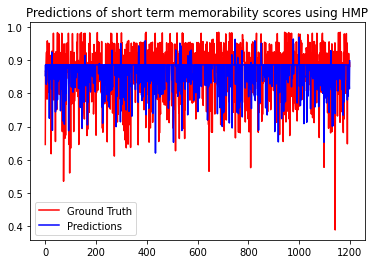

In [97]:
plt.plot(y_short_test, color = 'Red', label = 'Ground Truth')
plt.plot(NN_short_predictions, color = 'blue', label = 'Predictions')
plt.title('Predictions of short term memorability scores using HMP')
plt.legend()
plt.show()


Visualising the long term predictions of Neural Network model using HMP featues



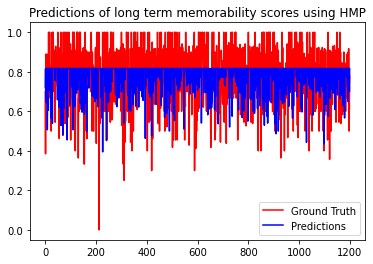

In [98]:
plt.plot(y_long_test, color = 'Red', label = 'Ground Truth')
plt.plot(NN_long_predictions, color = 'blue', label = 'Predictions')
plt.title('Predictions of long term memorability scores using HMP')
plt.legend()
plt.show()

### C3D+HMP features combined

Combining C3D with HMP features

In [100]:
'''C3D_HMP_fea = c3d_fea_list
counter_value = 0
for item_value in range(6000):
    C3D_HMP_fea[counter_value] = np.append(C3D_HMP_fea[counter_value],HMP_fea_list[counter_value],axis=0)
    counter_value = counter_value+1'''

In [118]:
C3D_values_sorted = c3d_final_df.iloc[0:,3:].values
HMP_values_sorted = HMP_final_df.iloc[0:,3:].values

#c3dAndCaption_features = np.concatenate((caption_features, c3d_features), axis=1)
C3D_HMP_fea = np.concatenate((C3D_values_sorted,HMP_values_sorted),axis =1)

In [119]:
len(C3D_HMP_fea)

6000

In [120]:
len(C3D_HMP_fea[0])

6176

In [121]:
C3D_HMP_df = pd.DataFrame(np.array(C3D_HMP_fea).reshape(6000,6176))

In [122]:
C3D_HMP_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,6136,6137,6138,6139,6140,6141,6142,6143,6144,6145,6146,6147,6148,6149,6150,6151,6152,6153,6154,6155,6156,6157,6158,6159,6160,6161,6162,6163,6164,6165,6166,6167,6168,6169,6170,6171,6172,6173,6174,6175
0,0.020249,0.001578,0.000826,0.000945,0.000063,0.000003,0.001162,0.000097,0.000022,0.000010,0.000337,0.000636,1.111700e-04,0.001008,0.000004,0.000631,3.905000e-05,0.000041,0.000091,0.000303,1.541000e-05,0.000032,5.221000e-05,0.000062,0.017465,0.000666,0.000065,0.000054,0.000273,0.001386,0.000003,0.001356,0.000517,2.426120e-03,0.002719,2.770000e-06,0.001557,0.000249,0.002632,0.000093,...,0.000002,0.000173,0.000459,0.000000,0.000148,0.000104,0.000000,0.000121,0.000551,0.000000,0.000114,0.000884,0.000002,0.000116,0.000077,0.000002,0.000027,0.000136,0.000000,0.000000,0.000002,0.000000,0.000091,0.000035,0.000000,0.000163,0.000467,0.000002,0.000010,0.000017,0.000000,0.000393,0.000279,0.000000,0.000289,0.001926,0.000000,0.000086,0.000580,0.000000
1,0.000118,0.000891,0.000188,0.000045,0.000063,0.000002,0.000641,0.000011,0.000017,0.000014,0.000336,0.004081,5.900000e-07,0.000411,0.000003,0.000243,6.600000e-07,0.000002,0.000535,0.000278,4.804000e-05,0.001153,2.792000e-05,0.000040,0.022276,0.004529,0.000020,0.000029,0.000045,0.060436,0.000039,0.027208,0.000074,2.719000e-05,0.000623,2.609600e-04,0.000183,0.000301,0.000102,0.012248,...,0.000685,0.000308,0.001054,0.000751,0.000176,0.000062,0.000000,0.000123,0.000398,0.000086,0.000246,0.000433,0.000446,0.000143,0.000053,0.000000,0.000053,0.000099,0.000009,0.000004,0.000033,0.000004,0.000051,0.000035,0.000000,0.000062,0.000358,0.000035,0.000024,0.000083,0.000053,0.000244,0.000066,0.000000,0.000081,0.000617,0.000094,0.000220,0.000762,0.001224
2,0.011765,0.000746,0.000784,0.000013,0.000007,0.000028,0.000041,0.000014,0.000041,0.000083,0.000048,0.000080,1.066610e-03,0.000958,0.000011,0.000070,2.992000e-05,0.000038,0.000031,0.000008,9.700000e-07,0.002905,1.849000e-05,0.000013,0.000192,0.000050,0.000532,0.000027,0.000051,0.000010,0.000005,0.000029,0.000033,3.260172e-02,0.000034,7.100000e-07,0.000006,0.001313,0.000064,0.000002,...,0.000083,0.000057,0.000158,0.000073,0.000021,0.000009,0.000002,0.000019,0.000095,0.000021,0.000019,0.000090,0.000073,0.000050,0.000024,0.000000,0.000012,0.000021,0.000000,0.000000,0.000002,0.000000,0.000017,0.000007,0.000002,0.000066,0.000203,0.000026,0.000002,0.000040,0.000007,0.000054,0.000045,0.000000,0.000028,0.000291,0.000033,0.000052,0.000258,0.000215
3,0.000223,0.000165,0.000007,0.000016,0.000005,0.000014,0.000154,0.000008,0.000004,0.000009,0.001057,0.000126,3.404000e-05,0.000004,0.000006,0.000012,1.940000e-06,0.000003,0.001759,0.000005,8.330000e-06,0.000027,3.200000e-07,0.000010,0.000137,0.000006,0.000005,0.000008,0.000008,0.000611,0.000166,0.583214,0.000004,2.100000e-07,0.000002,2.136000e-05,0.000003,0.000005,0.000003,0.004184,...,0.000210,0.000434,0.000543,0.000412,0.000412,0.000045,0.000003,0.000144,0.000282,0.000037,0.000197,0.000218,0.000157,0.000237,0.000021,0.000000,0.000040,0.000056,0.000008,0.000005,0.000013,0.000019,0.000168,0.000013,0.000000,0.000133,0.000202,0.000029,0.000029,0.000035,0.000059,0.001110,0.000075,0.000008,0.000333,0.000793,0.000101,0.000588,0.000503,0.000452
4,0.000090,0.000615,0.003436,0.001281,0.003551,0.000313,0.000042,0.000018,0.000157,0.000117,0.000256,0.000116,3.234800e-04,0.009888,0.000001,0.000576,3.004000e-05,0.000008,0.002029,0.000016,7.690000e-06,0.007324,2.863000e-05,0.000015,0.035220,0.000153,0.001053,0.000031,0.000026,0.001376,0.000215,0.001759,0.000013,1.698540e-03,0.000248,1.754577e-02,0.000260,0.000040,0.001630,0.000025,...,0.000160,0.000996,0.001604,0.000103,0.000768,0.000215,0.000009,0.000415,0.000926,0.000020,0.000538,0.001178,0.000050,0.000518,0.000169,0.000007,0.000134,0.000169,0.000007,0.000026,0.000046,0.000007,0.000373,0.000088,0.000000,0.000338,0.000441,0.000029,0.000070,0.000149,0.000009,0.000882,0.00020

Creeating a CSV to store the extracted C3D and HMP features

In [126]:
C3D_HMP_df.to_csv('/content/drive/My Drive/Features Files/C3D_HMP_df.csv')

In [127]:
C3D_HMP_df = pd.read_csv('/content/drive/My Drive/Features Files/C3D_HMP_df.csv')

In [128]:
C3D_HMP_df.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,6136,6137,6138,6139,6140,6141,6142,6143,6144,6145,6146,6147,6148,6149,6150,6151,6152,6153,6154,6155,6156,6157,6158,6159,6160,6161,6162,6163,6164,6165,6166,6167,6168,6169,6170,6171,6172,6173,6174,6175
0,0,0.020249,0.001578,0.000826,0.000945,0.000063,0.000003,0.001162,0.000097,0.000022,0.000010,0.000337,0.000636,1.111700e-04,0.001008,0.000004,0.000631,3.905000e-05,0.000041,0.000091,0.000303,1.541000e-05,0.000032,5.221000e-05,0.000062,0.017465,0.000666,0.000065,0.000054,0.000273,0.001386,0.000003,0.001356,0.000517,2.426120e-03,0.002719,2.770000e-06,0.001557,0.000249,0.002632,...,0.000002,0.000173,0.000459,0.000000,0.000148,0.000104,0.000000,0.000121,0.000551,0.000000,0.000114,0.000884,0.000002,0.000116,0.000077,0.000002,0.000027,0.000136,0.000000,0.000000,0.000002,0.000000,0.000091,0.000035,0.000000,0.000163,0.000467,0.000002,0.000010,0.000017,0.000000,0.000393,0.000279,0.000000,0.000289,0.001926,0.000000,0.000086,0.000580,0.000000
1,1,0.000118,0.000891,0.000188,0.000045,0.000063,0.000002,0.000641,0.000011,0.000017,0.000014,0.000336,0.004081,5.900000e-07,0.000411,0.000003,0.000243,6.600000e-07,0.000002,0.000535,0.000278,4.804000e-05,0.001153,2.792000e-05,0.000040,0.022276,0.004529,0.000020,0.000029,0.000045,0.060436,0.000039,0.027208,0.000074,2.719000e-05,0.000623,2.609600e-04,0.000183,0.000301,0.000102,...,0.000685,0.000308,0.001054,0.000751,0.000176,0.000062,0.000000,0.000123,0.000398,0.000086,0.000246,0.000433,0.000446,0.000143,0.000053,0.000000,0.000053,0.000099,0.000009,0.000004,0.000033,0.000004,0.000051,0.000035,0.000000,0.000062,0.000358,0.000035,0.000024,0.000083,0.000053,0.000244,0.000066,0.000000,0.000081,0.000617,0.000094,0.000220,0.000762,0.001224
2,2,0.011765,0.000746,0.000784,0.000013,0.000007,0.000028,0.000041,0.000014,0.000041,0.000083,0.000048,0.000080,1.066610e-03,0.000958,0.000011,0.000070,2.992000e-05,0.000038,0.000031,0.000008,9.700000e-07,0.002905,1.849000e-05,0.000013,0.000192,0.000050,0.000532,0.000027,0.000051,0.000010,0.000005,0.000029,0.000033,3.260172e-02,0.000034,7.100000e-07,0.000006,0.001313,0.000064,...,0.000083,0.000057,0.000158,0.000073,0.000021,0.000009,0.000002,0.000019,0.000095,0.000021,0.000019,0.000090,0.000073,0.000050,0.000024,0.000000,0.000012,0.000021,0.000000,0.000000,0.000002,0.000000,0.000017,0.000007,0.000002,0.000066,0.000203,0.000026,0.000002,0.000040,0.000007,0.000054,0.000045,0.000000,0.000028,0.000291,0.000033,0.000052,0.000258,0.000215
3,3,0.000223,0.000165,0.000007,0.000016,0.000005,0.000014,0.000154,0.000008,0.000004,0.000009,0.001057,0.000126,3.404000e-05,0.000004,0.000006,0.000012,1.940000e-06,0.000003,0.001759,0.000005,8.330000e-06,0.000027,3.200000e-07,0.000010,0.000137,0.000006,0.000005,0.000008,0.000008,0.000611,0.000166,0.583214,0.000004,2.100000e-07,0.000002,2.136000e-05,0.000003,0.000005,0.000003,...,0.000210,0.000434,0.000543,0.000412,0.000412,0.000045,0.000003,0.000144,0.000282,0.000037,0.000197,0.000218,0.000157,0.000237,0.000021,0.000000,0.000040,0.000056,0.000008,0.000005,0.000013,0.000019,0.000168,0.000013,0.000000,0.000133,0.000202,0.000029,0.000029,0.000035,0.000059,0.001110,0.000075,0.000008,0.000333,0.000793,0.000101,0.000588,0.000503,0.000452
4,4,0.000090,0.000615,0.003436,0.001281,0.003551,0.000313,0.000042,0.000018,0.000157,0.000117,0.000256,0.000116,3.234800e-04,0.009888,0.000001,0.000576,3.004000e-05,0.000008,0.002029,0.000016,7.690000e-06,0.007324,2.863000e-05,0.000015,0.035220,0.000153,0.001053,0.000031,0.000026,0.001376,0.000215,0.001759,0.000013,1.698540e-03,0.000248,1.754577e-02,0.000260,0.000040,0.001630,...,0.000160,0.000996,0.001604,0.000103,0.000768,0.000215,0.000009,0.000415,0.000926,0.000020,0.000538,0.001178,0.000050,0.000518,0.000169,0.000007,0.000134,0.000169,0.000007,0.000026,0.000046,0.000007,0.000373,0.000088,0.000000,0.000338,0.000441,0.000029,0.000070,0.000149,0.000009,0.000882,0.000200,0.000009,0.000559,0.00109

In [129]:
C3D_HMP_df.drop(C3D_HMP_df.columns[0] , axis =1, inplace = True)

In [130]:
C3D_HMP_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,6136,6137,6138,6139,6140,6141,6142,6143,6144,6145,6146,6147,6148,6149,6150,6151,6152,6153,6154,6155,6156,6157,6158,6159,6160,6161,6162,6163,6164,6165,6166,6167,6168,6169,6170,6171,6172,6173,6174,6175
0,0.020249,0.001578,0.000826,0.000945,0.000063,0.000003,0.001162,0.000097,0.000022,0.000010,0.000337,0.000636,1.111700e-04,0.001008,0.000004,0.000631,3.905000e-05,0.000041,0.000091,0.000303,1.541000e-05,0.000032,5.221000e-05,0.000062,0.017465,0.000666,0.000065,0.000054,0.000273,0.001386,0.000003,0.001356,0.000517,2.426120e-03,0.002719,2.770000e-06,0.001557,0.000249,0.002632,0.000093,...,0.000002,0.000173,0.000459,0.000000,0.000148,0.000104,0.000000,0.000121,0.000551,0.000000,0.000114,0.000884,0.000002,0.000116,0.000077,0.000002,0.000027,0.000136,0.000000,0.000000,0.000002,0.000000,0.000091,0.000035,0.000000,0.000163,0.000467,0.000002,0.000010,0.000017,0.000000,0.000393,0.000279,0.000000,0.000289,0.001926,0.000000,0.000086,0.000580,0.000000
1,0.000118,0.000891,0.000188,0.000045,0.000063,0.000002,0.000641,0.000011,0.000017,0.000014,0.000336,0.004081,5.900000e-07,0.000411,0.000003,0.000243,6.600000e-07,0.000002,0.000535,0.000278,4.804000e-05,0.001153,2.792000e-05,0.000040,0.022276,0.004529,0.000020,0.000029,0.000045,0.060436,0.000039,0.027208,0.000074,2.719000e-05,0.000623,2.609600e-04,0.000183,0.000301,0.000102,0.012248,...,0.000685,0.000308,0.001054,0.000751,0.000176,0.000062,0.000000,0.000123,0.000398,0.000086,0.000246,0.000433,0.000446,0.000143,0.000053,0.000000,0.000053,0.000099,0.000009,0.000004,0.000033,0.000004,0.000051,0.000035,0.000000,0.000062,0.000358,0.000035,0.000024,0.000083,0.000053,0.000244,0.000066,0.000000,0.000081,0.000617,0.000094,0.000220,0.000762,0.001224
2,0.011765,0.000746,0.000784,0.000013,0.000007,0.000028,0.000041,0.000014,0.000041,0.000083,0.000048,0.000080,1.066610e-03,0.000958,0.000011,0.000070,2.992000e-05,0.000038,0.000031,0.000008,9.700000e-07,0.002905,1.849000e-05,0.000013,0.000192,0.000050,0.000532,0.000027,0.000051,0.000010,0.000005,0.000029,0.000033,3.260172e-02,0.000034,7.100000e-07,0.000006,0.001313,0.000064,0.000002,...,0.000083,0.000057,0.000158,0.000073,0.000021,0.000009,0.000002,0.000019,0.000095,0.000021,0.000019,0.000090,0.000073,0.000050,0.000024,0.000000,0.000012,0.000021,0.000000,0.000000,0.000002,0.000000,0.000017,0.000007,0.000002,0.000066,0.000203,0.000026,0.000002,0.000040,0.000007,0.000054,0.000045,0.000000,0.000028,0.000291,0.000033,0.000052,0.000258,0.000215
3,0.000223,0.000165,0.000007,0.000016,0.000005,0.000014,0.000154,0.000008,0.000004,0.000009,0.001057,0.000126,3.404000e-05,0.000004,0.000006,0.000012,1.940000e-06,0.000003,0.001759,0.000005,8.330000e-06,0.000027,3.200000e-07,0.000010,0.000137,0.000006,0.000005,0.000008,0.000008,0.000611,0.000166,0.583214,0.000004,2.100000e-07,0.000002,2.136000e-05,0.000003,0.000005,0.000003,0.004184,...,0.000210,0.000434,0.000543,0.000412,0.000412,0.000045,0.000003,0.000144,0.000282,0.000037,0.000197,0.000218,0.000157,0.000237,0.000021,0.000000,0.000040,0.000056,0.000008,0.000005,0.000013,0.000019,0.000168,0.000013,0.000000,0.000133,0.000202,0.000029,0.000029,0.000035,0.000059,0.001110,0.000075,0.000008,0.000333,0.000793,0.000101,0.000588,0.000503,0.000452
4,0.000090,0.000615,0.003436,0.001281,0.003551,0.000313,0.000042,0.000018,0.000157,0.000117,0.000256,0.000116,3.234800e-04,0.009888,0.000001,0.000576,3.004000e-05,0.000008,0.002029,0.000016,7.690000e-06,0.007324,2.863000e-05,0.000015,0.035220,0.000153,0.001053,0.000031,0.000026,0.001376,0.000215,0.001759,0.000013,1.698540e-03,0.000248,1.754577e-02,0.000260,0.000040,0.001630,0.000025,...,0.000160,0.000996,0.001604,0.000103,0.000768,0.000215,0.000009,0.000415,0.000926,0.000020,0.000538,0.001178,0.000050,0.000518,0.000169,0.000007,0.000134,0.000169,0.000007,0.000026,0.000046,0.000007,0.000373,0.000088,0.000000,0.000338,0.000441,0.000029,0.000070,0.000149,0.000009,0.000882,0.00020

### Train Test split for C3D+HMP

In [131]:
X = C3D_HMP_df.iloc[0:,0:].values
y = ground_truth_data.iloc[:, 1:3].values 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

### ML models with C3D+HMP features

Linear Regression

In [132]:
LNR_model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [133]:
LNR_predictions = LNR_model.predict(X_test)
Get_score(LNR_predictions, y_test)

The Spearman's correlation coefficient is: 0.023
The Spearman's correlation coefficient is: 0.024


Random Forest

In [134]:
RFR_model = RandomForestRegressor(n_estimators=1000, max_depth= 60, max_leaf_nodes= 3,max_features = 4, bootstrap = True,random_state = 42, verbose = 2)
RFR_model.fit(X_train, y_train)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 1000
building tree 2 of 1000
building tree 3 of 1000
building tree 4 of 1000
building tree 5 of 1000
building tree 6 of 1000
building tree 7 of 1000
building tree 8 of 1000
building tree 9 of 1000
building tree 10 of 1000
building tree 11 of 1000
building tree 12 of 1000
building tree 13 of 1000
building tree 14 of 1000
building tree 15 of 1000
building tree 16 of 1000
building tree 17 of 1000
building tree 18 of 1000
building tree 19 of 1000
building tree 20 of 1000
building tree 21 of 1000
building tree 22 of 1000
building tree 23 of 1000
building tree 24 of 1000
building tree 25 of 1000
building tree 26 of 1000
building tree 27 of 1000
building tree 28 of 1000
building tree 29 of 1000
building tree 30 of 1000
building tree 31 of 1000
building tree 32 of 1000
building tree 33 of 1000
building tree 34 of 1000
building tree 35 of 1000
building tree 36 of 1000
building tree 37 of 1000
building tree 38 of 1000
building tree 39 of 1000
building tree 40 of 1000
building 

[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    4.4s finished


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=60, max_features=4, max_leaf_nodes=3,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=None, oob_score=False,
                      random_state=42, verbose=2, warm_start=False)

In [135]:
RFR_predictions = RFR_model.predict(X_test)
Get_score(RFR_predictions, y_test)

The Spearman's correlation coefficient is: 0.277
The Spearman's correlation coefficient is: 0.105


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.2s finished


Gradient Boosting

Training separately for short term and long term

In [137]:
y_short_term = ground_truth_data.iloc[:,1:2].values
y_long_term = ground_truth_data.iloc[:,2:3].values

X_short_train,X_short_test,y_short_train,y_short_test = train_test_split(X,y_short_term,test_size=0.2,random_state=40)
X_long_train,X_long_test,y_long_train,y_long_test = train_test_split(X,y_long_term,test_size=0.2,random_state=40)

Gradient boosting for short term

In [138]:
GBR_model= GradientBoostingRegressor()
GBR_model.fit(X_short_train,y_short_train)

GBR_short_predictions = GBR_model.predict(X_short_test)
Get_score(GBR_short_predictions,y_short_test)

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The Spearman's correlation coefficient is: 0.326


Gradient boosting for long term

In [139]:
GBR_model.fit(X_long_train,y_long_train)

GBR_long_predictions = GBR_model.predict(X_long_test)
Get_score(GBR_long_predictions,y_long_test)

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The Spearman's correlation coefficient is: 0.126


Neural Network

Scaling the input data

In [140]:
std_sc = StandardScaler()
X_short_train = std_sc.fit_transform(X_short_train)
X_short_test = std_sc.transform(X_short_test)

X_long_train = std_sc.fit_transform(X_long_train)
X_long_test = std_sc.transform(X_long_test)

In [144]:
# Initialising the NN model
NN_model = Sequential()

# Input layer and first hidden layer is added
NN_model.add(Dense(32, activation = 'relu', input_dim = 6176))

# Second hidden layer is added
NN_model.add(Dense(units = 32, activation = 'relu'))

# Third hidden layer is added
NN_model.add(Dense(units = 32, activation = 'relu'))

# Output layer is added
NN_model.add(Dense(units = 1))

Compiling the Neural Network model

In [146]:
NN_model.compile(optimizer = 'adam',loss = 'mean_squared_error')

Neural Network- short term predictions with C3D+HMP features

In [147]:
NN_model.fit(X_short_train, y_short_train, batch_size = 10, epochs = 45)
NN_short_predictions = NN_model.predict(X_short_test)
Get_score(NN_short_predictions, y_short_test)

Epoch 1/45
480/480 [==============================] - 2s 3ms/step - loss: 0.2696
Epoch 2/45
480/480 [==============================] - 1s 3ms/step - loss: 0.0571
Epoch 3/45
480/480 [==============================] - 1s 3ms/step - loss: 0.0861
Epoch 4/45
480/480 [==============================] - 1s 3ms/step - loss: 0.0396
Epoch 5/45
480/480 [==============================] - 1s 3ms/step - loss: 0.0159
Epoch 6/45
480/480 [==============================] - 1s 3ms/step - loss: 0.0144
Epoch 7/45
480/480 [==============================] - 1s 3ms/step - loss: 0.0094
Epoch 8/45
480/480 [==============================] - 1s 3ms/step - loss: 0.0079
Epoch 9/45
480/480 [==============================] - 1s 3ms/step - loss: 0.0082
Epoch 10/45
480/480 [==============================] - 1s 3ms/step - loss: 0.0096
Epoch 11/45
480/480 [==============================] - 1s 3ms/step - loss: 0.0072
Epoch 12/45
480/480 [==============================] - 1s 3ms/step - loss: 0.0083
Epoch 13/45
480/480 [====

Neural Network- long term predictions with C3D+HMP features

In [148]:
NN_model.fit(X_long_train, y_long_train, batch_size = 10, epochs = 45)
NN_long_predictions = NN_model.predict(X_long_test)
Get_score(NN_long_predictions, y_long_test)

Epoch 1/45
480/480 [==============================] - 1s 3ms/step - loss: 0.0212
Epoch 2/45
480/480 [==============================] - 1s 3ms/step - loss: 0.0212
Epoch 3/45
480/480 [==============================] - 1s 3ms/step - loss: 0.0212
Epoch 4/45
480/480 [==============================] - 1s 3ms/step - loss: 0.0211
Epoch 5/45
480/480 [==============================] - 1s 3ms/step - loss: 0.0212
Epoch 6/45
480/480 [==============================] - 1s 3ms/step - loss: 0.0212
Epoch 7/45
480/480 [==============================] - 1s 3ms/step - loss: 0.0212
Epoch 8/45
480/480 [==============================] - 1s 3ms/step - loss: 0.0211
Epoch 9/45
480/480 [==============================] - 1s 3ms/step - loss: 0.0212
Epoch 10/45
480/480 [==============================] - 1s 3ms/step - loss: 0.0212
Epoch 11/45
480/480 [==============================] - 1s 3ms/step - loss: 0.0212
Epoch 12/45
480/480 [==============================] - 1s 3ms/step - loss: 0.0212
Epoch 13/45
480/480 [====

# Test-Set

Importing tabular results

From the results above, we can see that the HMP features yielded the best result for the Random Forest model for both short term and long term

Training the model with full Dev-set with 6000 videos

In [201]:
X = HMP_final_df.iloc[0:,3:].values
y = ground_truth_data.iloc[:,1:3].values


In [202]:
RFR_model = RandomForestRegressor(n_estimators=1000, max_depth= 60, max_leaf_nodes= 3,max_features = 4, bootstrap = True,random_state = 42, verbose = 2)
RFR_model.fit(X,y)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 1000
building tree 2 of 1000
building tree 3 of 1000
building tree 4 of 1000
building tree 5 of 1000
building tree 6 of 1000
building tree 7 of 1000
building tree 8 of 1000
building tree 9 of 1000
building tree 10 of 1000
building tree 11 of 1000
building tree 12 of 1000
building tree 13 of 1000
building tree 14 of 1000
building tree 15 of 1000
building tree 16 of 1000
building tree 17 of 1000
building tree 18 of 1000
building tree 19 of 1000
building tree 20 of 1000
building tree 21 of 1000
building tree 22 of 1000
building tree 23 of 1000
building tree 24 of 1000
building tree 25 of 1000
building tree 26 of 1000
building tree 27 of 1000
building tree 28 of 1000
building tree 29 of 1000
building tree 30 of 1000
building tree 31 of 1000
building tree 32 of 1000
building tree 33 of 1000
building tree 34 of 1000
building tree 35 of 1000
building tree 36 of 1000
building tree 37 of 1000
building tree 38 of 1000
building tree 39 of 1000
building tree 40 of 1000
building 

[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    3.9s finished


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=60, max_features=4, max_leaf_nodes=3,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=None, oob_score=False,
                      random_state=42, verbose=2, warm_start=False)

Importing test data set

In [161]:
test_ground_truth = pd.read_csv('/content/drive/MyDrive/CA684_Assignment/Test-set/Ground-truth_test/ground_truth_template.csv')

In [162]:
test_ground_truth.shape

(2000, 5)

In [163]:
test_ground_truth.head()

,video,short-term_memorability,nb_short-term_annotations,long-term_memorability,nb_long-term_annotations
0,7494,NaN,33,NaN,12
1,7495,NaN,34,NaN,10
2,7496,NaN,32,NaN,13
3,7497,NaN,33,NaN,10
4,7498,NaN,33,NaN,10


Importing HMP test dataset

In [190]:
def read_HMP(fname):
    """Scan HMP(Histogram of Motion Patterns) features from file"""
    with open(fname) as f:
        for line in f:
            pairs=line.split()
            HMP_temp = { int(p.split(':')[0]) : float(p.split(':')[1]) for p in pairs}
    # there are 6075 bins, fill zeros
    HMP = np.zeros(6075)
    for idx in HMP_temp.keys():
        HMP[idx-1] = HMP_temp[idx]            
    return HMP

In [195]:
HMP_test_list= []
HMP_video_test = []
for filename in glob.glob('/content/drive/MyDrive/CA684_Assignment/Test-set/HMP_test/*.txt'):
    HMP_data= read_HMP(filename)
    HMP_test_list.append(HMP_data)
    HMP_video_name = filename.split('/')[-1].split('.')[0]
    HMP_video_num = HMP_video_name[5:]
    HMP_video_test.append(HMP_video_num) 

In [196]:
HMP_test_df = pd.DataFrame(np.array(HMP_test_list).reshape(2000,6075))
HMP_test_df["video"] = HMP_video_test

In [197]:
HMP_test_df.shape

(2000, 6076)

In [198]:
HMP_test_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,6036,6037,6038,6039,6040,6041,6042,6043,6044,6045,6046,6047,6048,6049,6050,6051,6052,6053,6054,6055,6056,6057,6058,6059,6060,6061,6062,6063,6064,6065,6066,6067,6068,6069,6070,6071,6072,6073,6074,video
0,0.002060,0.000583,0.000011,0.0,0.000395,0.000031,0.0,0.000000,0.000007,0.0,0.0,0.0,0.0,0.000035,0.000000,0.0,0.000000,0.000002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000901,0.001298,0.000085,0.000370,0.000221,0.000007,0.000421,0.000616,0.000026,0.000526,0.000793,0.000033,0.000346,0.000145,0.000000,0.000129,0.000186,0.000011,0.000022,0.000035,0.000000,0.000173,0.000088,0.000004,0.000270,0.000368,0.000015,0.000083,0.000072,0.000004,0.000366,0.000169,0.000002,0.000388,0.000590,0.000033,0.000655,0.000671,0.000055,8763
1,0.015623,0.005571,0.000267,0.0,0.003743,0.000415,0.0,0.000002,0.000082,0.0,0.0,0.0,0.0,0.000805,0.000124,0.0,0.000002,0.000024,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000845,0.000984,0.000260,0.000468,0.000141,0.000007,0.000247,0.000498,0.000055,0.000457,0.000457,0.000115,0.000382,0.000097,0.000002,0.000099,0.000152,0.000015,0.000026,0.000037,0.000007,0.000205,0.000060,0.000004,0.000265,0.000406,0.000033,0.000068,0.000062,0.000049,0.000944,0.000185,0.000007,0.000439,0.000955,0.000084,0.000851,0.000752,0.000273,8758
2,0.005330,0.001166,0.000002,0.0,0.000927,0.000011,0.0,0.000000,0.000004,0.0,0.0,0.0,0.0,0.000074,0.000000,0.0,0.000000,0.000002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000293,0.000617,0.000185,0.000170,0.000101,0.000007,0.000246,0.000393,0.000034,0.000288,0.000384,0.000150,0.000087,0.000029,0.000002,0.000025,0.000034,0.000002,0.000002,0.000013,0.000007,0.000096,0.000058,0.000000,0.000139,0.000130,0.000018,0.000016,0.000040,0.000018,0.000092,0.000025,0.000016,0.000107,0.000199,0.000009,0.000152,0.000188,0.000092,8768
3,0.040748,0.016237,0.000303,0.0,0.007668,0.000118,0.0,0.000000,0.000033,0.0,0.0,0.0,0.0,0.002083,0.000107,0.0,0.000000,0.000013,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000383,0.001531,0.000004,0.000053,0.000316,0.000000,0.000114,0.000630,0.000000,0.000118,0.001318,0.000002,0.000047,0.000151,0.000000,0.000056,0.000180,0.000000,0.000027,0.000100,0.000000,0.000016,0.000020,0.000000,0.000082,0.000238,0.000000,0.000018,0.000100,0.000002,0.000058,0.000154,0.000000,0.000125,0.000530,0.000000,0.000073,0.000572,0.000002,8764
4,0.056045,0.012873,0.000278,0.0,0.006645,0.000157,0.0,0.000000,0.000069,0.0,0.0,0.0,0.0,0.001593,0.000112,0.0,0.000000,0.000016,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000152,0.000217,0.000114,0.000027,0.000013,0.000002,0.000083,0.000096,0.000011,0.000056,0.000110,0.000045,0.000063,0.000016,0.000000,0.000018,0.000018,0.000004,0.000004,0.000002,0.000000,0.000020,0.000009,0.000000,0.000036,0.000103,0.000009,0.000002,0.000018,0.000025,0.000074,0.000027,0.000004,0.000036,0.000305,0.000011,0.000087,0.000217,0.000345,8760


In [199]:
HMP_test_values = HMP_test_df.iloc[:,0:6075].values

[2.06e-03 5.83e-04 1.10e-05 ... 6.55e-04 6.71e-04 5.50e-05]


In [203]:
HMP_predictions = RFR_model.predict(HMP_test_values)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.2s finished


In [204]:
type(HMP_predictions)

numpy.ndarray

In [205]:
final_predictions = pd.DataFrame()

In [210]:
final_predictions['video'] = HMP_test_df.iloc[:,6075:].values
final_predictions['short-term'] = HMP_predictions[:,0]
final_predictions['long-term']  = HMP_predictions[:,1]


In [211]:
final_predictions.head()

,short-term,long-term,video
0,0.853878,0.770430,8763
1,0.851192,0.767574,8758
2,0.858650,0.777737,8768
3,0.860638,0.778794,8764
4,0.864610,0.783664,8760


In [212]:
final_predictions.shape

(2000, 3)

In [213]:
final_predictions.to_csv('/content/drive/My Drive/Features Files/final_predictions2.csv',index=False)
